# Intuition

We are provided with the information that a certain interval $0\leq t_1 < t_2 \leq T$ is corrupted in terms of the covariance structure of the data. This implies that there are *two* distinct points of regime change exactly at $t_1$ and $t_2$: from the regular state to corrupted state at $t_1$, and back to the regular state from the corrupted state at $t_2$.

In the context of principal component analysis, consider that when the data feed enters corrupted state at $t_1$, the explained variance ratio/eigenvalues of the first few principal components should change in a drastic fashion. From $t_1$ to $t_2$, although we do not know exactly the behavior of the data in the corrupted state, we would expect no *drastic* change. Again at $t_2$, the EVR/eigenvalues should shift *drastically*, indicating the change back to regular state. 

Hence, to solve for $t_1$, $t_2$, it suffices to define some metric that captures the changes in first few EVR/eigenvalues, and take the biggest 2 changes as the candidates for $t_1$ and $t_2$.

In [99]:
import numpy as np
import csv

def pca_power(matrix, n, max_iter=1000, tolerance=1e-10):
    it = 0
    oldnormw = 0.
    v = np.random.random(n)
    w = np.zeros(n)
    
    while it < max_iter:
        w = matrix.dot(v)
        normw = (np.inner(w,w))**.5
        v = w/normw
        if np.abs(normw - oldnormw)/normw < tolerance:
            break
        oldnormw = normw
        it += 1
    return normw, v

def pca_power_full(matrix, n, max_iter=1000, tolerance=1e-10, n_components=10):
    vals = np.zeros(n_components)
    vecs = np.zeros((n_components, n))
    for i in range(n_components):
        val, vec = pca_power(matrix, n, max_iter, tolerance)
        matrix -= val * np.outer(vec, vec)
        vals[i] = val
        np.copyto(vecs[i], vec)
    return vals, vecs


def runpower(matrix, n):
    #get initial vector

    v = np.zeros(n)
    w = np.zeros(n)

    for j in range(n):
        v[j] = np.random.uniform(0,1)

    #print 'matrix', matrix
    #print 'v', v

    maxiters = 1000
    tolerance = 1e-10
    oldnormw = 0.
    for t in range(maxiters):
        w = matrix.dot(v)
        #print 't', t, 'w',w
        normw = (np.inner(w,w))**.5
        
        v = w/normw
        #print 't',t,'v',v

        #print 't',t,'normw',normw, 'old', oldnormw
        if np.abs(normw - oldnormw)/normw < tolerance:
            #print ' breaking'
            break
        oldnormw = normw

    return normw, v    

def read_data(data_dir:str = "../data/", filename="polluteddeltas.csv") -> np.ndarray:
    filename = data_dir + filename
    f = open(filename,'r')
    csvf = csv.reader(f)
    polluteddeltalist = list(csvf)
    f.close() 
    plist = np.array(polluteddeltalist)
    polluteddata = plist.astype(float) 
    return polluteddata

In [100]:
d = read_data()[:,1:]
d.shape

(1709, 30)

In [101]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Explained variance ratio:
[0.69931657 0.18172515 0.04460281 0.02042211 0.01101976 0.0062027
 0.00423162 0.00319432 0.00291293 0.00249516]

Leading eigenvalue:
[2340.86224733 1193.29127401  591.18046737  400.026997    293.84952153
  220.45978904  182.09263381  158.20795445  151.07891883  139.82606664]


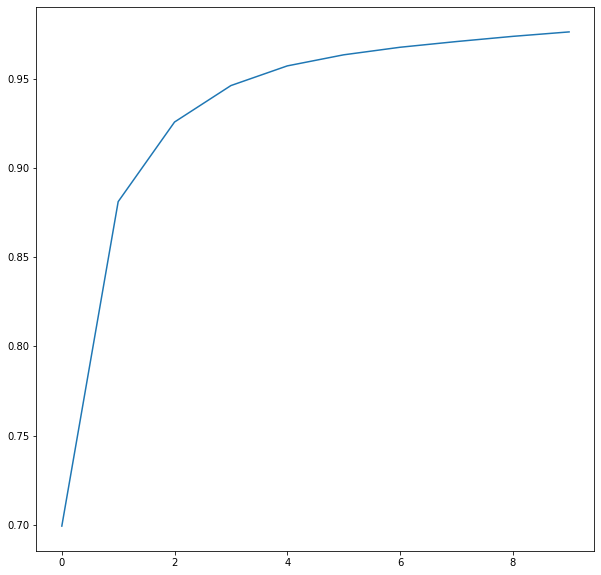

In [102]:
pca = PCA(10)
pca.fit(d)
print("Explained variance ratio:")
evr = pca.explained_variance_ratio_
print(evr)
print()
print("Leading eigenvalue:")
eig1 = pca.singular_values_
print(eig1)
fig, ax = plt.subplots(1,1,figsize = [10, 10])
ax.plot(evr.cumsum())

In [103]:
n_components = 10
pca = PCA(n_components)
T, k = d.shape
w = 500
dt = 1

eigs = np.zeros((T, n_components))
evrs = np.zeros((T, n_components))

for t in range(0, T-w, dt):
    pca.fit(d[t:t+w])
    eigs[t] = pca.singular_values_[:n_components]
    evrs[t] = pca.explained_variance_ratio_[:n_components]

# for t in range(k, T,dt):
#     pca.fit(d[:t])
#     eigs[t] = pca.singular_values_[:n_components]
#     evrs[t] = pca.explained_variance_ratio_[:n_components]

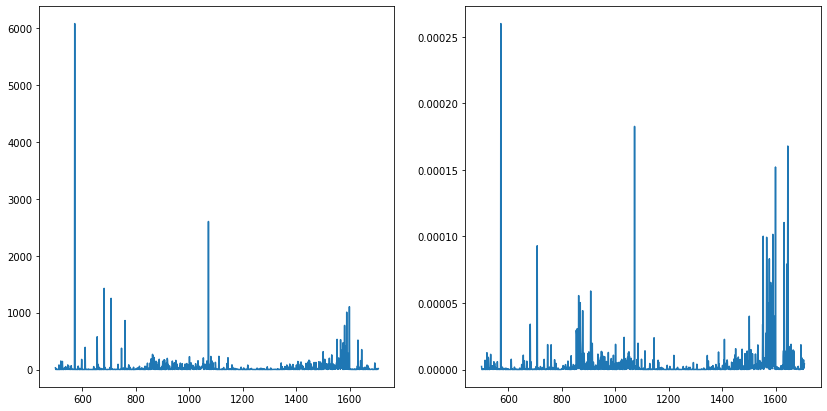

In [104]:
fig, ax = plt.subplots(1,2,figsize = [14,7])

# ax.plot(eig1s[:T-w])
# ax[0].plot(eigs[:T-w:dt])
# ax[1].plot(evrs[:T-w:dt])
deigs = np.diff(eigs[:T-w], axis = 0)
devrs = np.diff(evrs[:T-w], axis = 0)

# ax[0].plot(np.arange(w, T-1), deigs)
# ax[1].plot(np.arange(w, T-1), devrs)

deigs_sse = (np.diff(eigs[:T-w], axis = 0)**2).sum(axis = 1)
devrs_sse = (np.diff(evrs[:T-w], axis = 0)**2).sum(axis = 1)


ax[0].plot(np.arange(w, T-1), deigs_sse)
ax[1].plot(np.arange(w, T-1), devrs_sse)

In [105]:
print("Eigenvalues Diff:")
print("\t1st:")
print(np.argsort(deigs_sse)[-1] + w)
print("\t2nd:")
print(np.argsort(deigs_sse)[-2] + w)
print()
print("Explained Variance Ratio:")
print("\t1st:")
print(np.argsort(devrs_sse)[-1] + w)
print("\t2nd:")
print(np.argsort(devrs_sse)[-2] + w)

Eigenvalues Diff:
	1st:
572
	2nd:
1072

Explained Variance Ratio:
	1st:
572
	2nd:
1072
